<a href="https://colab.research.google.com/github/4GeeksAcademy/series-temporales-python-template/blob/main/Series_Temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [27]:
#Pasar las fechas a objeto de datetime
data["date"] = pd.to_datetime(data.date)
data = data.set_index("date")
ts_total = data["sales"]
ts_total.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

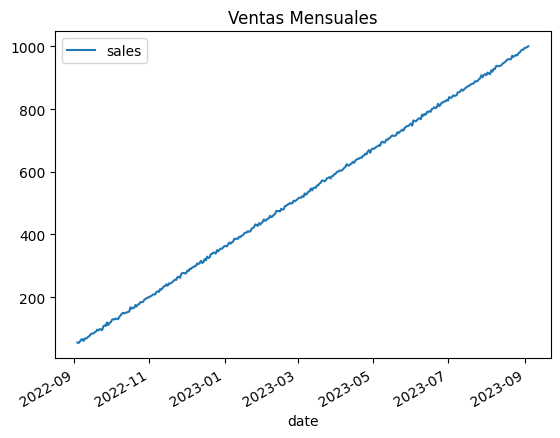

ADF Statistic: 0.5454141937063742
p-value: 0.9861899815311063


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Graficar la serie temporal
data.plot()
plt.title('Ventas Mensuales')
plt.show()

# Prueba de estacionariedad
result = adfuller(data['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])



Rechazamos hipotesis nula, por lo que existen diferencias significativas, es decir, no es estacionaria.

In [29]:
!pip install pmdarima

from pmdarima import auto_arima

# Entrenar el modelo ARIMA
arima_model = auto_arima(data['sales'], seasonal=True, m=12)
print(arima_model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Tue, 11 Jun 2024   AIC                           1839.552
Time:                        08:07:39   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.0

Podemos ver como todos las valores del p valor son significativos a excepcion de ar.L1 lo que sugiere que no hay una fuerte dependencia lineal entre los valores actuales y los valores anteriores en la serie temporal, ya hemos visto que no es estacionaria. El coeficiente ma.L1 indica que los residuos del modelo anterior tienen un fuerte impacto en el modelo actual. El tercer coeficiente, sigma, es la varianza de los errores y sugiere que hay una variabilidad considerable en la serie temporal que no es explicada por el modelo. Ljung-Box indica ausencia de autocorrelación en los residuos.Tampoco existe heterocedasticidad y con Jarque-Bera concluimos que sigue una distribucion normal.

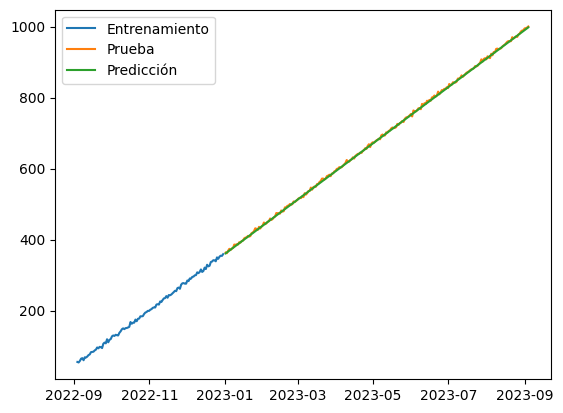

Mean Squared Error: 9.880753526578465


In [30]:
import datetime as dt

# Dividir los datos en entrenamiento y prueba
train = data[:dt.datetime(2022, 12, 31)]
test = data[dt.datetime(2023, 1, 1):]

# Ajustar el modelo y predecir
arima_model.fit(train)
forecast = arima_model.predict(n_periods=len(test))

# Comparar con los datos reales
plt.plot(train.index, train['sales'], label='Entrenamiento')
plt.plot(test.index, test['sales'], label='Prueba')
plt.plot(test.index, forecast, label='Predicción')
plt.legend()
plt.show()

# Medir el rendimiento
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test['sales'], forecast)
print(f'Mean Squared Error: {mse}')


Descomposicion de la serie

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_total, period = 12)
decomposition

Analisis de tendencias

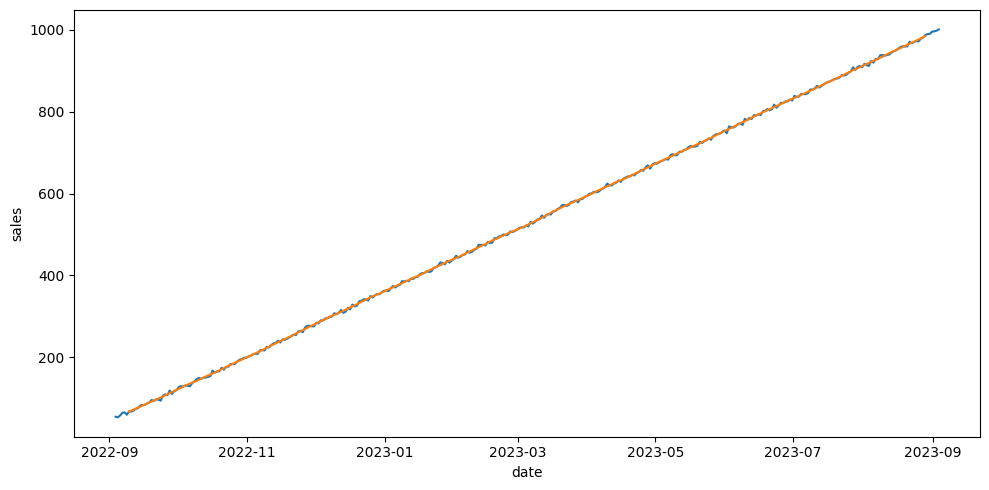

In [32]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Podemos ver el aumento de las ventas.

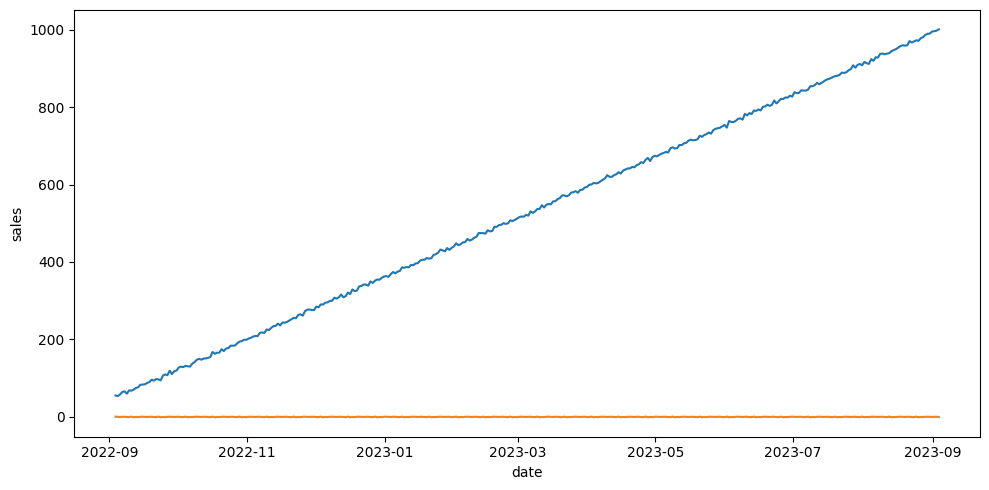

In [33]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Ya se comprobo que no era estacionaria, aun asi el procedimiento a seguir seria realizar el test de Dickey-Fuller

In [34]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts_total)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Variabilidad

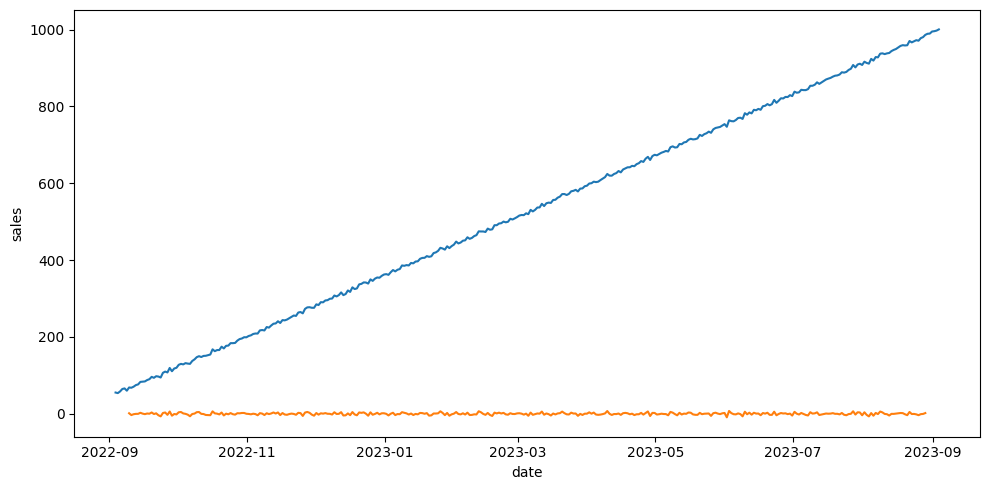

In [35]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Autocorrelacion

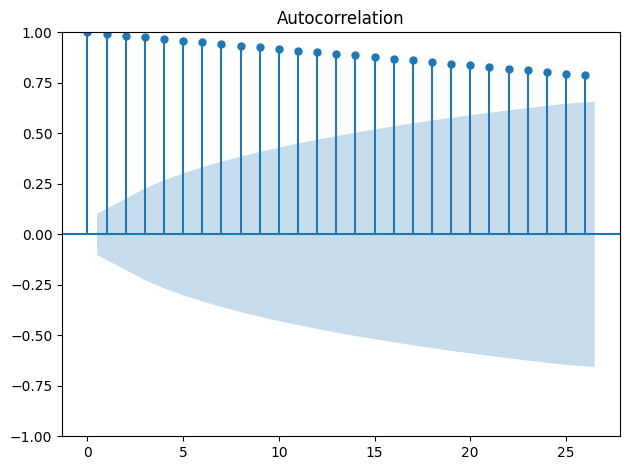

In [36]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts_total)

plt.tight_layout()

plt.show()

Entrenamiento del modelo :  lo único que tenemos que considerar es que para optimizar al máximo sus resultados, debemos transformar la serie en estacionaria, y como en el caso de esta serie no lo es, debemos transformarla:

In [37]:
ts_stationary = ts_total.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Ya es estacionaria.

In [50]:
from pmdarima import auto_arima

model = auto_arima(ts_total, seasonal = True, trace = True, m = 10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[10] intercept   : AIC=1846.800, Time=2.26 sec
 ARIMA(0,1,0)(0,0,0)[10] intercept   : AIC=2096.542, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[10] intercept   : AIC=1972.485, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[10] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[10]             : AIC=2209.657, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[10] intercept   : AIC=1844.381, Time=1.24 sec
 ARIMA(2,1,2)(0,0,0)[10] intercept   : AIC=1843.274, Time=0.77 sec
 ARIMA(2,1,2)(1,0,0)[10] intercept   : AIC=1844.274, Time=1.81 sec
 ARIMA(1,1,2)(0,0,0)[10] intercept   : AIC=1843.586, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[10] intercept   : AIC=1841.532, Time=1.41 sec
 ARIMA(2,1,1)(1,0,0)[10] intercept   : AIC=1842.671, Time=3.22 sec
 ARIMA(2,1,1)(0,0,1)[10] intercept   : AIC=1842.716, Time=1.72 sec
 ARIMA(2,1,1)(1,0,1)[10] intercept   : AIC=1845.740, Time=2.16 sec
 ARIMA(1,1,1)(0,0,0)[10] intercept   : AIC=1839.552, Time=0.41 sec
 ARIMA(1,1,1)(1,0,0)[10]

El mejor modelo es el (1,1,1)(0,0,0), comprobamos que tiene el AIC más pequeño

In [53]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Tue, 11 Jun 2024   AIC                           1839.552
Time:                        08:29:22   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Prediccion de modelo

In [54]:
forecast = model.predict(100)
forecast

2023-09-04 17:10:08.079328    1002.158148
2023-09-05 17:10:08.079328    1004.831669
2023-09-06 17:10:08.079328    1007.423289
2023-09-07 17:10:08.079328    1010.021630
2023-09-08 17:10:08.079328    1012.619419
                                 ...     
2023-12-08 17:10:08.079328    1249.022047
2023-12-09 17:10:08.079328    1251.619878
2023-12-10 17:10:08.079328    1254.217709
2023-12-11 17:10:08.079328    1256.815540
2023-12-12 17:10:08.079328    1259.413371
Freq: D, Length: 100, dtype: float64

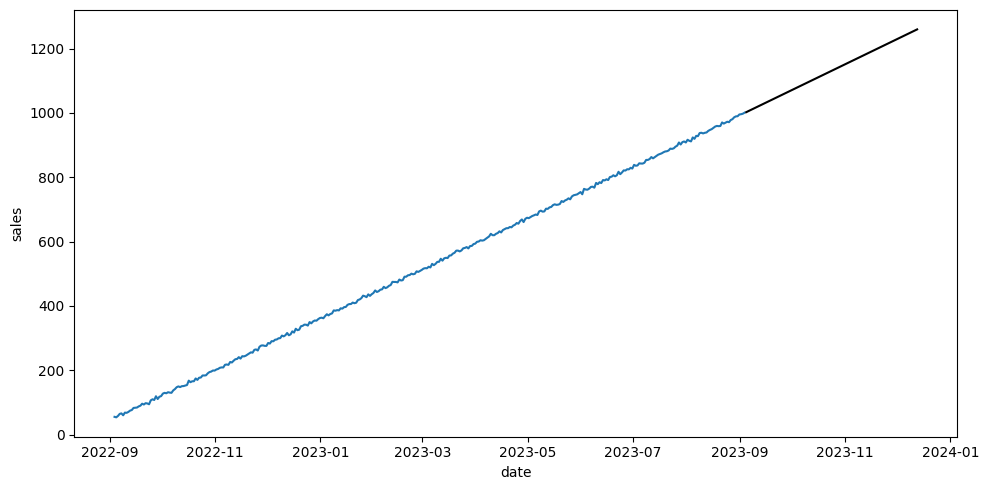

In [55]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = forecast, c = "black")

plt.tight_layout()

plt.show()

Ahora nuestro modelo es capaz de realizar predicciones a futuro sobre nuestra serie estacionaria.

In [56]:
from pickle import dump

dump(model, open("series_temporales.sav", "wb"))
dump(model, open("series_temporales.csv", "wb"))